<a href="https://colab.research.google.com/github/rightbin/Deep-learning/blob/main/38_0_vehicle_classification_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Vehicle Type Classification Project**



# Summary


- **Use Case:** Vehicle Type
- **Algorithm:** MobileNetV2
- **Number of training images:** 603
- **Number of classes:** 7
- **Batch Size:** 64
- **Optimizer:** Adam 
- **Learning Rate:** 0.0001
- **Loss Type:**CategoricalCrossentropy
- **Transfer Learning:** Yes | Imagenet



 ## Labels
 
 0: 'car-bus-alltypes',

 1: 'car-sedan-alltypes',
 
 2: 'car-suv-alltypes',
 
 3: 'motocycle-bicycle-kids',
 
 4: 'motocycle-bicycle-racing',
 
 5: 'motocycle-motorbike-chopper',
 
 6: 'motocycle-motorbike-sport'

## Import Library

In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf
import h5py
import numpy as np
import sys

In [ ]:
print(tf.__version__)

2.4.1


## 구글드라이브 마운트 하기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 다음 데이터셋을 다운로드하여, 압축을 풀고, 구글 드라이브에 올려놓는다.

https://drive.google.com/file/d/1oAW1QoG77-WLPkPa2tAM4Mnpt1cznnDl/view?usp=sharing


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/day19')

In [4]:
!unzip 38_실습파일.zip

Archive:  38_실습파일.zip
   creating: test-images/
  inflating: __MACOSX/._test-images  
  inflating: test-images/bicycle.png  
  inflating: __MACOSX/test-images/._bicycle.png  
  inflating: test-images/bus.jpg     
  inflating: __MACOSX/test-images/._bus.jpg  
   creating: trained-models/
  inflating: __MACOSX/._trained-models  
   creating: trained-models/mobilenetv2/
  inflating: __MACOSX/trained-models/._mobilenetv2  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-1.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehicle-classification-by-type-mobilenetv2-anis-1.h5  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-1-2.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehicle-classification-by-type-mobilenetv2-anis-1-2.h5  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-2.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehicle-classifica

## 경로 셋팅

In [5]:
TYPE='type'
model_type='mobilenetv2'
user='block'
iteration='1-2'

first_time_training=True

PROJECT_PATH= '/content/drive/MyDrive/Colab Notebooks/day19'

HDF5_DATASET_PATH=PROJECT_PATH+'/vehicle_datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5'

TARGET_CLASSIFICATION_MODEL=PROJECT_PATH+'/trained-models/'+model_type+'/'+'vehicle-classification-by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'

CHECKPOINT_PATH = PROJECT_PATH+'/checkpoints/'+model_type+'/'+'by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'

LOGFILE_PATH=PROJECT_PATH+'/log/'+model_type+'/'+model_type+'-by-'+TYPE+'-training-log'+user+'-'+iteration+'.csv'


어떤 에포크가 제일 좋은 것인지 찾아주는 코드(위에꺼)
accuracy가 제일 높은 것을 찾아주는 것임. 
overfitting이 된 것을 배포하면 난리나는 거임. 지금 에포크가 전에꺼보다 좋다면 이걸 저장하는 거임. 그래서 그다음 에포크가 좋다면 그걸 저장 하는 식으로 하는 거임...(Check point만 확인하면 됨 그러면 어디서 제일 좋은 수치로 저장 되었는지를 알 수 있음.)


In [6]:
print('PROJECT_PATH: ',PROJECT_PATH)
print('HDF5_DATASET_PATH: ', HDF5_DATASET_PATH)
print('TARGET_CLASSIFICATION_MODEL: ',TARGET_CLASSIFICATION_MODEL)
print('CHECKPOINT_PATH: ',CHECKPOINT_PATH)
print('LOGFILE_PATH: ',LOGFILE_PATH)

PROJECT_PATH:  /content/drive/MyDrive/Colab Notebooks/day19
HDF5_DATASET_PATH:  /content/drive/MyDrive/Colab Notebooks/day19/vehicle_datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5
TARGET_CLASSIFICATION_MODEL:  /content/drive/MyDrive/Colab Notebooks/day19/trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-block-1-2.h5
CHECKPOINT_PATH:  /content/drive/MyDrive/Colab Notebooks/day19/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5
LOGFILE_PATH:  /content/drive/MyDrive/Colab Notebooks/day19/log/mobilenetv2/mobilenetv2-by-type-training-logblock-1-2.csv


In [7]:

sys.path.append(PROJECT_PATH)


# **Load the Dataset**

In [11]:
hf = h5py.File(HDF5_DATASET_PATH,'r')

hf['trainY']
np.array(hf['trainY']) #눈으로 보고 싶다면 이렇게 써주면 됨.


array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [12]:
np.array(hf['trainY'][0,]) # 5번째의 1이 있기 때문에 위에 Label을 보면 모터사이클임을 알 수 있다.

array([0, 0, 0, 0, 0, 1, 0])

In [13]:
def load_dataset_from_hdf5_file(hdf_file_path):
  # 함수 만들기
  hf = h5py.File(hdf_file_path,'r')

  X_train = np.array(hf['trainX'])
  y_train = np.array(hf['trainY'])
  train_label = np.array(hf['trainLabels'])

  X_test = np.array(hf['testX'])
  y_test = np.array(hf['testY'])
  test_label = np.array(hf['testLabels'])

  X_val = np.array(hf['devX'])
  y_val = np.array(hf['devY'])
  val_label = np.array(hf['devLabels'])

  return X_train,y_train,train_label,X_test,y_test,test_label,X_val,y_val,val_label

In [15]:
X_train,y_train,train_label,X_test,y_test,test_label,X_val,y_val,val_label=load_dataset_from_hdf5_file(HDF5_DATASET_PATH) #함수 호출하는 코드

In [ ]:
train_label

In [30]:
X_train.shape

(603, 224, 224, 3)

# 사진이미지 확인해 보기

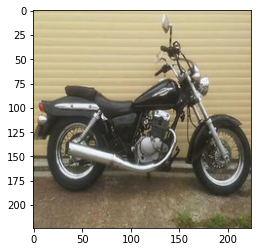

In [25]:
plt.imshow(X_train[1])

In [21]:
X_train[0].min() #이미 정규화가 되어있다. 255로 이미 나눈 상태임....

0.0

In [27]:
y_train[1]

array([0, 0, 0, 0, 0, 1, 0])

In [26]:
y_train[1].argmax()

5

In [28]:
train_label[1]

b'motocycle-motorbike-chopper'

# 모델링하기 : 트랜스퍼 러닝 적용

# Data Augmentation

In [48]:
trainGen = ImageDataGenerator(rotation_range=20,
                              horizontal_flip = True)

In [51]:
baseModel = MobileNetV2( weights='imagenet',include_top=False ,
                        input_shape = (224,224,3))

In [ ]:
baseModel.summary()

In [52]:
headModel = baseModel.output

In [53]:
headModel = AveragePooling2D((4,4))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = BatchNormalization()(headModel) #overfitting을 막는 거임.
headModel = Dense(64,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dense(7,activation='softmax')(headModel)


In [54]:
baseModel.trainable = False

In [55]:
model = Model(inputs = baseModel.input, outputs = headModel)

###  콜백 만들기 : 가장 좋은 모델을 자동 저장하도록 함. 로그도 저장하도록 함.

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
import pickle 

In [56]:
cp = ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_accuracy',
                     save_best_only = True, verbose= 1)

In [57]:
csv_logger = CSVLogger(filename=LOGFILE_PATH,append = True)

## 컴파일과 학습 : 에포크는 50

In [58]:
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics='accuracy')

In [59]:
CHECKPOINT_PATH

'/content/drive/MyDrive/Colab Notebooks/day19/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5'

In [60]:
LOGFILE_PATH

'/content/drive/MyDrive/Colab Notebooks/day19/log/mobilenetv2/mobilenetv2-by-type-training-logblock-1-2.csv'

In [61]:
if not os.path.exists(PROJECT_PATH+'/checkpoints/'+model_type+'/'):
  os.makedirs(PROJECT_PATH+'/checkpoints/'+model_type+'/')

if not os.path.exists(PROJECT_PATH+'/log/'+model_type+'/'):
  os.makedirs(PROJECT_PATH+'/log/'+model_type+'/')

In [ ]:
history = model.fit(trainGen.flow(X_train,y_train,batch_size=64),
                    #만 개의 데이터를5000개씩 학습하면, steps_per_epoch는 2가 된다. 
                    #만 개의 데이터를 한 개씩 학습하면, steps_per_epoch는 10000이 된다. 
                    steps_per_epoch = len(X_train) // 64 ,
                    validation_data = (X_val, y_val),
                    validation_steps = len(X_val) // 64,
                    callbacks = [cp , csv_logger],
                    epochs = 50
                    )

# 트레이닝 및 밸리데이션의 정확도와 로스를 차트로 보기

In [103]:
def learning_curve(history, epoch):
  # 정확도 차트
  plt.figure(figsize=(15,20))
  epoch_range = np.arange(1, epoch+1)

  plt.subplot(2, 1, 1)

  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accruacy')
  plt.legend(['Train, Val'])
  
  plt.show()
  # loss 차트

  plt.subplot(2,1,1)

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train, Val'])

  plt.show()

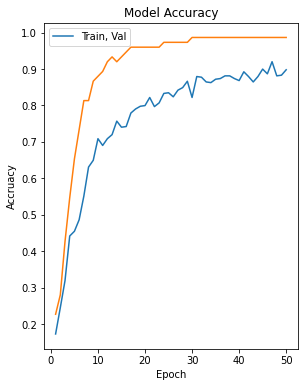

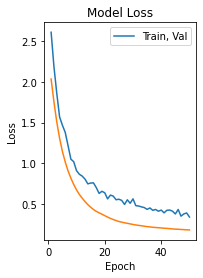

In [65]:
learning_curve(history, 50)

In [66]:
model.evaluate(X_test,y_test)

3/3 [==============================] - 1s 66ms/step - loss: 0.2512 - accuracy: 0.9605


[0.25122520327568054, 0.9605262875556946]

# 모델 평가

In [69]:
y_pred = model.predict(X_test)

In [71]:
y_pred.argmax(axis=1)

array([0, 2, 0, 1, 6, 1, 4, 4, 3, 4, 3, 1, 2, 4, 0, 0, 0, 6, 3, 2, 6, 5,
       6, 3, 4, 5, 3, 0, 3, 2, 6, 0, 0, 3, 0, 5, 6, 4, 3, 2, 1, 1, 1, 2,
       6, 0, 3, 1, 3, 3, 2, 3, 4, 0, 6, 5, 5, 5, 2, 1, 3, 5, 5, 1, 0, 5,
       1, 0, 1, 3, 1, 4, 4, 6, 2, 6])

In [72]:
y_pred = y_pred.argmax(axis=1)

In [73]:
y_pred

array([0, 2, 0, 1, 6, 1, 4, 4, 3, 4, 3, 1, 2, 4, 0, 0, 0, 6, 3, 2, 6, 5,
       6, 3, 4, 5, 3, 0, 3, 2, 6, 0, 0, 3, 0, 5, 6, 4, 3, 2, 1, 1, 1, 2,
       6, 0, 3, 1, 3, 3, 2, 3, 4, 0, 6, 5, 5, 5, 2, 1, 3, 5, 5, 1, 0, 5,
       1, 0, 1, 3, 1, 4, 4, 6, 2, 6])

In [74]:
y_test.argmax(axis=1)

array([0, 1, 0, 1, 6, 1, 4, 4, 3, 4, 3, 1, 2, 4, 0, 0, 0, 6, 3, 2, 6, 5,
       6, 3, 4, 5, 3, 0, 3, 2, 6, 0, 0, 3, 0, 5, 6, 4, 3, 2, 2, 1, 1, 2,
       6, 0, 4, 1, 3, 3, 2, 3, 4, 0, 6, 5, 5, 5, 2, 1, 3, 5, 5, 1, 0, 5,
       1, 0, 1, 3, 1, 4, 4, 6, 2, 6])

In [75]:
y_test = y_test.argmax(axis=1)

In [76]:
y_test

array([0, 1, 0, 1, 6, 1, 4, 4, 3, 4, 3, 1, 2, 4, 0, 0, 0, 6, 3, 2, 6, 5,
       6, 3, 4, 5, 3, 0, 3, 2, 6, 0, 0, 3, 0, 5, 6, 4, 3, 2, 2, 1, 1, 2,
       6, 0, 4, 1, 3, 3, 2, 3, 4, 0, 6, 5, 5, 5, 2, 1, 3, 5, 5, 1, 0, 5,
       1, 0, 1, 3, 1, 4, 4, 6, 2, 6])

In [67]:
from sklearn.metrics import confusion_matrix

In [77]:
cm = confusion_matrix(y_test,y_pred)

In [78]:
import seaborn as sns

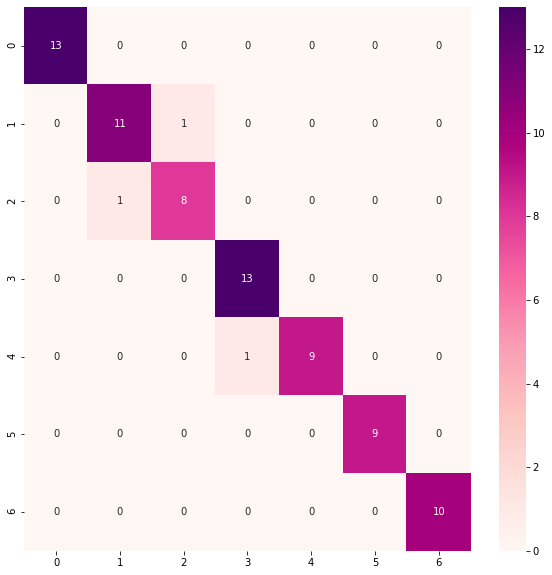

In [80]:
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='.0f',cmap='RdPu')
plt.show()

Fine 튜닝하기


In [ ]:
baseModel.summary()

In [82]:
len(baseModel.layers)

154

In [84]:
len(model.layers) - len(baseModel.layers)

8

In [85]:
start_layer = 120

In [86]:
baseModel.trainable = True

In [87]:
for layer in baseModel.layers[ 0  : start_layer  ]:
  layer.trainable = False

In [88]:
model.compile(optimizer=Adam(lr=0.0001),
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])



In [ ]:
history = model.fit(trainGen.flow(X_train,y_train,batch_size=64),
                    #만 개의 데이터를5000개씩 학습하면, steps_per_epoch는 2가 된다. 
                    #만 개의 데이터를 한 개씩 학습하면, steps_per_epoch는 10000이 된다. 
                    steps_per_epoch = len(X_train) // 64 ,
                    validation_data = (X_val, y_val),
                    validation_steps = len(X_val) // 64,
                    callbacks = [cp , csv_logger],
                    epochs = 50
                    )

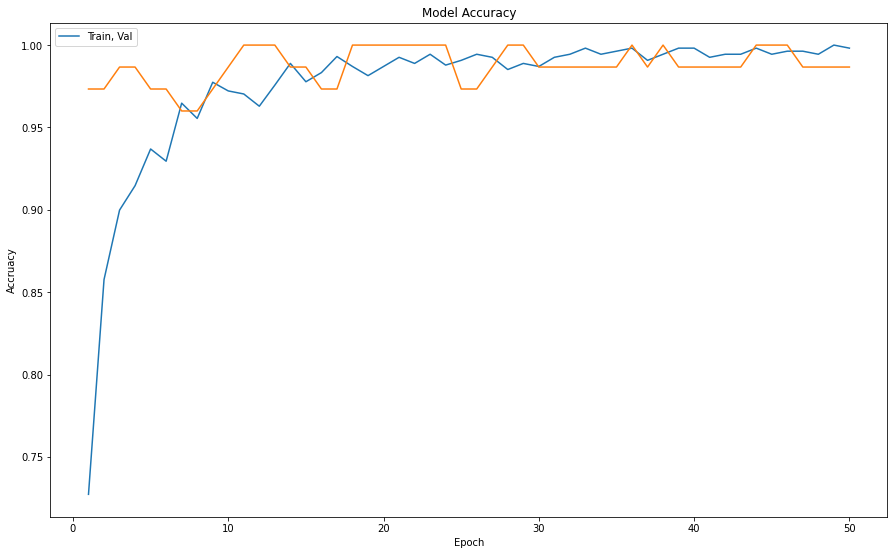

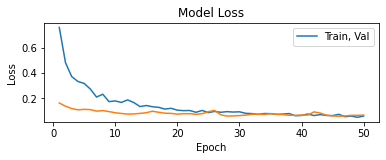

In [104]:
learning_curve(history, 50)

In [91]:
y_pred = model.predict(X_test)

In [95]:
y_pred = y_pred.argmax(axis=1)

In [96]:
y_test

array([0, 1, 0, 1, 6, 1, 4, 4, 3, 4, 3, 1, 2, 4, 0, 0, 0, 6, 3, 2, 6, 5,
       6, 3, 4, 5, 3, 0, 3, 2, 6, 0, 0, 3, 0, 5, 6, 4, 3, 2, 2, 1, 1, 2,
       6, 0, 4, 1, 3, 3, 2, 3, 4, 0, 6, 5, 5, 5, 2, 1, 3, 5, 5, 1, 0, 5,
       1, 0, 1, 3, 1, 4, 4, 6, 2, 6])

In [97]:
cm = confusion_matrix(y_test,y_pred)

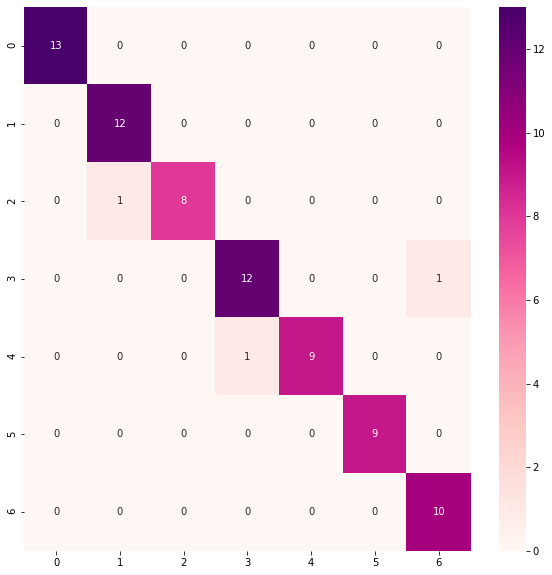

In [98]:
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='.0f',cmap='RdPu')
plt.show()